### MLDA@EEE Deep Learning Week Special:
# **Text Generator using RNN Workshop**

In this workshop, we assumed that you have attended the workshops in pre-deep learning week and have basic knowledge of Python programming, deep learning as well as neural network. If not, don't worry, as you will be instructed step by step in this pratical session to apply what you learnt during the tutorial session. If you encounter any technical issues or need assistance from us, you can ask us in the ZOOM chat and a helper will come to you as soon as possible.

The structure of this pratical session is listed below:
1. Text Processing Basics
2. Model Building from scratch
3. Model Building using Keras

## **1. Text Processing Basics**

### Tokenization

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

sentences = [
    'I love coffee',
    'I love tea.',
    'I love MLDA!'
]

tokenizer = Tokenizer(num_words = 32)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

test_sen = [
    'I like coffee...',
    'You really love tea',
    'We love MLDA!'
]

test_seq = tokenizer.texts_to_sequences(test_sen)
print(test_seq)

In [ ]:
sentences = [
    'You love coffee',
    'He loves tea so much.',
    'I really love MLDA!'
]

tokenizer = Tokenizer(num_words = 32, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)

test_sen = [
    'I like coffee...',
    'You really love tea',
    'We love MLDA!'
]

test_seq = tokenizer.texts_to_sequences(test_sen)
print(test_seq)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 32, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences, maxlen=5)
print(word_index)
print(sequences)
print(padded)

## **2. Build Text Generator from scratch**

In [ ]:
import tensorflow as tf
import numpy as np

path = '/content/drive/My Drive/Colab Notebooks/lyrics.txt'
# Read, then decode for py2 compat.
text = open(path, 'r').read()
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))
print(text[:250])

In [ ]:
stopChars = [',','(',')','.','-','[',']','"','/','&','!','\'','?']
corpus = text.replace('\n', ' ').replace('\t',' ').lower()
for char in stopChars:
  corpus = corpus.replace(char, '')
corpus = corpus.replace('  ', ' ')
print(corpus[:300])

In [ ]:
corpus_words = [w for w in corpus.split(' ')]
corpus_words[:5]

In [ ]:
corpus_words = [i for i in corpus_words if i]

In [ ]:
map(str.strip, corpus_words)
vocab = sorted(set(corpus_words))
print('Corpus length (in words):', len(corpus_words))
print('Unique words in corpus: {}'.format(len(vocab)))
word2idx = {u: i for i, u in enumerate(vocab)}
idx2words = np.array(vocab)
word_as_int = np.array([word2idx[c] for c in corpus_words])
print(word2idx)

### Prediction

In [ ]:
# The maximum length sentence we want for a single input in words
seqLength = 10
examples_per_epoch = len(corpus_words)//(seqLength + 1) # number of seqLength+1 sequences in the corpus

# Create training / targets batches
wordDataset = tf.data.Dataset.from_tensor_slices(word_as_int)
sequencesOfWords = wordDataset.batch(seqLength + 1, drop_remainder=True) # generating batches of 10 words each, typically converting list of words (sequence) to string

def split_input_target(chunk): # This is where right shift happens
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text # returns training and target sequence for each batch

dataset = sequencesOfWords.map(split_input_target) # dataset now contains a training and a target sequence for each 10 word slice of the corpus

In [ ]:
BATCH_SIZE = 64 # each batch contains 64 sequences. Each sequence contains 10 words (seqLength)
BUFFER_SIZE = 100 # Number of batches that will be processed concurrently

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Length of the vocabulary in words
vocab_size = len(vocab)
# The embedding dimension
embedding_dim = 256
# Number of GRU units
rnn_units = 1024

def createModel(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

model = createModel(vocab_size = len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE)
model.summary()

In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
model.compile(optimizer='adam', loss=loss)
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS)

In [ ]:
model = createModel(len(vocab), embedding_dim, rnn_units, batch_size=1)
model.build(tf.TensorShape([1, None]))

def generateLyrics(model, startString, temp):
  print("---- Generating lyrics starting with '" + startString + "' ----")
  # Number of words to generate
  num_generate = 30

  # Converting our start string to numbers (vectorizing)
  start_string_list =  [w for w in startString.split(' ')]
  input_eval = [word2idx[s] for s in start_string_list]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # temp represent how 'conservative' the predictions are. 
      # Lower temp leads to more predictable (or correct) lyrics
      predictions = predictions / temp 
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(' ' + idx2words[predicted_id])

  return (startString + ''.join(text_generated))
generateLyrics(model, 'love', 0.5)

## **3. Build the Model using Keras**

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

path = '/content/drive/My Drive/Colab Notebooks/lyrics.txt'
# Read, then decode for py2 compat.
text = open(path, 'r').read()
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))
print(text[:250])

Length of text: 245664 characters
A Day In The Life
-----------------
I read the news today oh boy
About a lucky man who made the grade
And though the news was rather sad
Well I just had to laugh
I saw the photograph.
He blew his mind out in a car
He didn't notice that the lights hav


In [2]:
tokenizer = Tokenizer()

corpus = text.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'you': 1, 'i': 2, 'the': 3, 'me': 4, 'to': 5, 'and': 6, 'a': 7, 'love': 8, 'my': 9, 'in': 10, 'be': 11, 'that': 12, "don't": 13, 'it': 14, 'do': 15, 'all': 16, "i'm": 17, 'on': 18, 'your': 19, 'of': 20, 'is': 21, 'oh': 22, 'know': 23, 'so': 24, 'she': 25, "it's": 26, 'for': 27, 'when': 28, 'baby': 29, 'can': 30, 'but': 31, 'now': 32, 'her': 33, 'well': 34, 'no': 35, 'if': 36, 'got': 37, 'what': 38, 'with': 39, 'want': 40, 'just': 41, 'see': 42, 'come': 43, 'say': 44, 'like': 45, 'one': 46, "you're": 47, "i'll": 48, 'girl': 49, 'yeah': 50, 'gonna': 51, 'little': 52, 'get': 53, 'go': 54, 'down': 55, 'will': 56, 'time': 57, "she's": 58, 'let': 59, 'never': 60, 'tell': 61, 'was': 62, 'day': 63, 'said': 64, 'yeh': 65, 'back': 66, 'we': 67, 'they': 68, 'how': 69, 'there': 70, 'way': 71, "can't": 72, 'make': 73, 'man': 74, 'good': 75, 'have': 76, 'over': 77, "i've": 78, 'here': 79, 'are': 80, 'long': 81, 'not': 82, 'he': 83, 'up': 84, 'hey': 85, 'as': 86, "that's": 87, 'night': 88, 'take': 8

In [7]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
# max_sequence_len = max([len(x) for x in input_sequences])
max_sequence_len = 33
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, labels = input_sequences[:,:-1],input_sequences[:,-1]
label = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [8]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.25))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           315300    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32, 300)           301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1576)              159176    
_________________________________________________________________
dense_3 (Dense)              (None, 3153)              4972281   
Total params: 5,908,357
Trainable params: 5,908,357
Non-trainable params: 0
____________________________________________

In [61]:
history = model.fit(predictors, label, epochs=5, verbose=1)

Epoch 1/5
1290/1290 [==============================] - 21s 17ms/step - loss: 5.4942 - accuracy: 0.0607
Epoch 2/5
1211/1290 [===========================>..] - ETA: 1s - loss: 5.4196 - accuracy: 0.0658

KeyboardInterrupt: ignored

In [5]:
# import os
# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# # Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1, period=20)
# model.fit(predictors, label, epochs=100, verbose=1, callbacks = [cp_callback])

In [ ]:
# model.save('model.h5')

In [ ]:
# new_model = tf.keras.models.load_model('model.h5')
# new_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 58, 64)            201792    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 58, 256)           197632    
_________________________________________________________________
dropout_13 (Dropout)         (None, 58, 256)           0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 64)                82176     
_________________________________________________________________
dense_34 (Dense)             (None, 1576)              102440    
_________________________________________________________________
dense_35 (Dense)             (None, 3153)              4972281   
Total params: 5,556,321
Trainable params: 5,556,321
Non-trainable params: 0
___________________________________________

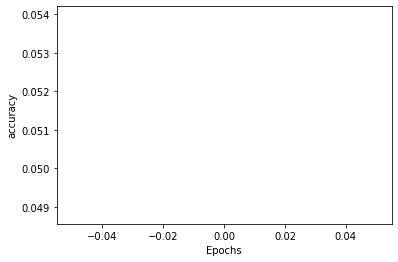

In [52]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()
plot_graphs(history, 'accuracy')

In [59]:
seed_text = "One day"
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

One day i know you know you know you know you know


## **Build the Model - Shakespeare**

In text generation, we try to predict the next character or word of the sequence. The text data generally considered as sequence of data. For predicting data in sequence we used deep learning models like RNN or LSTM. LSTM are preferred over RNN in this because of RNN vanishing and exploding gradients problem. Since in text generation we have to memorize large amount of previous data. So for this purpose LSTM are preferred.

The phrases in text are nothing but sequence of words. So, LSTM can be used to predict the next word. The neural network take sequence of words as input and output will be a matrix of probability for each word from dictionary to be next of given sequence. The model will also learn how much similarity is between each words or characters and will calculate the probability of each. Using that we will predict or generate next word or character of sequence.

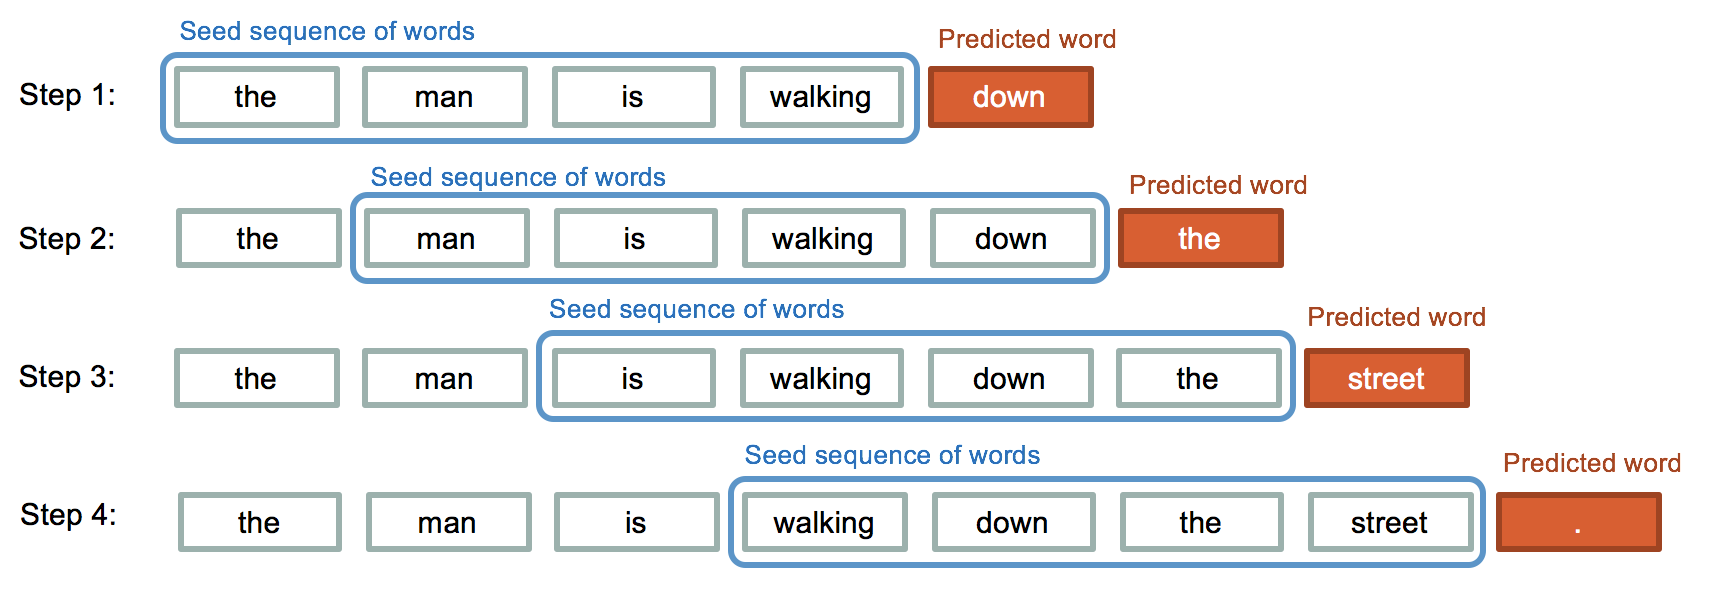

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time
#Download the dataset
path_to_file = tf.keras.utils.get_file('shakespeare.txt',
                                       'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
#Explore the data
text = open(path_to_file, 'r').read()
print(text[:100])

In [ ]:
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

In [ ]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])
print('{')
for char,_ in zip(char2idx, range(10)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

In [ ]:
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

In [ ]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

In [ ]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

In [ ]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
  print("Step {:4d}".format(i))
  print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
  print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [ ]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

In [ ]:
model.summary()

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [ ]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS=200

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

In [ ]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 0.6

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
    predictions = model(input_eval)
    # remove the batch dimension
    predictions = tf.squeeze(predictions, 0)

    # using a categorical distribution to predict the character returned by the model
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    # We pass the predicted character as the next input to the model
    # along with the previous hidden state
    input_eval = tf.expand_dims([predicted_id], 0)

    text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
print(generate_text(model, start_string=u"Lord: "))